In [2]:
!pip install seaborn

You should consider upgrading via the '/home/milselarch/projects/aisg_venv/bin/python3.9 -m pip install --upgrade pip' command.


In [3]:
from IPython.display import display, HTML
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn.metrics
import sklearn
import ast

In [4]:
labels_df = pd.read_csv('../../stats/all-labels.csv')
display(labels_df)

,filename,label,audio_fake,face_fake,swap_fake,both_fake
0,9a22372d22a52397.mp4,1,1.0,1.0,0,1
1,9bc4f1306bb8e2cd.mp4,1,1.0,1.0,0,1
2,88fe2a902a9d8cc7.mp4,1,1.0,1.0,0,1
3,1f3cbda142d0944a.mp4,1,1.0,1.0,0,1
4,63bed62257daccaf.mp4,1,1.0,1.0,0,1
...,...,...,...,...,...,...
6938,f5c4bfb20068f129.mp4,0,0.0,0.0,0,0
6939,b7b7b7f6db7f6e2e.mp4,0,0.0,0.0,0,0
6940,c3fc75289ae3b41e.mp4,0,0.0,0.0,0,0
6941,519e97d4c90aaa1c.mp4,0,0.0,0.0,0,0


In [17]:
def load_vid_preds(path):
    vid_preds = pd.read_csv(path)
    vid_preds = vid_preds.groupby('filename', sort=False, as_index=False).agg(min)
    vid_preds = pd.merge(
        left=labels_df, right=vid_preds, 
        left_on='filename', right_on='filename'
    )

    vid_preds['diff'] = vid_preds['mean_pred'] - vid_preds['median_pred']
    return vid_preds

def draw_roc(labels, preds):
    fpr, tpr, _ = sklearn.metrics.roc_curve(labels, preds)
    auc = sklearn.metrics.roc_auc_score(labels, preds)

    plt.style.use('ggplot')
    plt.figure(figsize=(12, 5))
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.05, 1.05])
    plt.title("CV regression ROC. AUC="+str(round(auc, 10)))
    plt.plot(fpr, tpr)
    
def get_acc(df, column):
    preds = df[column].to_numpy()
    labels = df['swap_fake'].to_numpy()
    pred_labels = (preds > 0.5).astype(int)
    correct_count = sum(pred_labels == labels)
    acc = correct_count / len(preds)
    return acc
    
def sub_draw_roc(vid_preds, select_files, column='median_pred'):
    sub_vid_preds = vid_preds[
        vid_preds['filename'].isin(select_files) |
        vid_preds['swap_fake'] == 1
    ]

    # display(sub_vid_preds)
    # print(vid_preds)
    sync_preds = sub_vid_preds[column]
    sync_labels = sub_vid_preds['swap_fake']
    
    real_rows = sub_vid_preds[sub_vid_preds['swap_fake'] == 0]
    fake_rows = sub_vid_preds[sub_vid_preds['swap_fake'] == 1]
    
    real_acc = get_acc(real_rows, column)
    fake_acc = get_acc(fake_rows, column)
    print(f'real acc: {real_acc}')
    print(f'fake acc: {fake_acc}')
    draw_roc(sync_labels, sync_preds)

In [18]:
old_vid_preds = load_vid_preds('../stats/vid-dataset-211209-0226.csv')
display(old_vid_preds)

,filename,label,audio_fake,face_fake,swap_fake,both_fake,mean_pred,median_pred,1st_quartile_pred,3rd_quartile_pred,std_pred,max_pred,min_pred,face_no,diff
0,18351609de111566.mp4,1,0.0,0.0,1,0,0.886478,0.991882,0.877936,0.999761,0.213244,1.000000,0.180236,0,-0.105404
1,5026338ed12800bc.mp4,1,0.0,0.0,1,0,0.771807,0.937751,0.705958,0.991937,0.306803,1.000000,0.004848,0,-0.165944
2,5968740ef3396f0c.mp4,1,0.0,0.0,1,0,0.908657,0.997838,0.957127,0.999761,0.197435,1.000000,0.030951,0,-0.089181
3,50e301013618719d.mp4,1,0.0,0.0,1,0,0.689604,0.765472,0.535128,0.919209,0.280081,0.999999,0.059797,0,-0.075868
4,bc6dd15cfdfe6175.mp4,1,0.0,0.0,1,0,0.798933,0.991416,0.705039,0.999836,0.306610,1.000000,0.025240,0,-0.192483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3262,f5c4bfb20068f129.mp4,0,0.0,0.0,0,0,0.322102,0.280690,0.135136,0.444732,0.228058,0.986776,0.010469,0,0.041412
3263,b7b7b7f6db7f6e2e.mp4,0,0.0,0.0,0,0,0.019183,0.006369,0.001618,0.020698,0.034796,0.281572,0.000011,0,0.012814
3264,c3fc75289ae3b41e.mp4,0,0.0,0.0,0,0,0.056983,0.028271,0.006577,0.064418,0.086561,0.548783,0.000074,0,0.028712
3265,519e97d4c90aaa1c.mp4,0,0.0,0.0,0,0,0.155874,0.104358,0.042252,0.214259,0.175576,0.744065,0.000468,0,0.051515


In [19]:
train_files = open('../saves/checkpoints/211207-0123/train.txt').read()
train_files = ast.literal_eval(train_files)
print('train files:', len(train_files), train_files[:10])

test_files = open('../saves/checkpoints/211207-0123/test.txt').read()
test_files = ast.literal_eval(test_files)
print('test files:', len(test_files), test_files[:10])

train files: 2295 ['c59d2549456ad02a.mp4', '56d59930ddf61239.mp4', '8a4caf49711d8edf.mp4', 'f88e40b475cd6a70.mp4', '1a81b12442a68f4c.mp4', 'b2bd5f005134dda4.mp4', '8995bd37e6aeed6a.mp4', '91fff341619c8124.mp4', '326b8d65f8678680.mp4', 'df234b6a4267dad2.mp4']
test files: 256 ['1c56956bc6540dd9.mp4', '6cf1650746f6a984.mp4', '3a80a52b6017096c.mp4', '519e97d4c90aaa1c.mp4', '2811815d3da7463d.mp4', '865683a96c834074.mp4', 'e304f9060ca59b48.mp4', 'c2fd2b49874c8d4a.mp4', 'e7c1248f1566506d.mp4', '7b00b4246abeba8b.mp4']


(array([2.48709503, 5.81489824, 8.79240638, 9.00258343, 8.72234737,
        9.49299653, 7.70649165, 6.86578347, 5.46460317, 4.51880647,
        3.81821632, 2.24188848, 1.61135734, 0.98082621, 0.52544261,
        0.17514754, 0.28023606, 0.35029507, 0.17514754, 0.31526557,
        0.21017704, 0.03502951, 0.14011803, 0.10508852, 0.03502951,
        0.03502951, 0.        , 0.07005901, 0.03502951, 0.07005901,
        0.10508852, 0.        , 0.07005901, 0.03502951, 0.        ,
        0.03502951, 0.        , 0.03502951, 0.        , 0.03502951]),
 array([0.00137761, 0.01381655, 0.02625548, 0.03869442, 0.05113336,
        0.06357229, 0.07601123, 0.08845017, 0.10088911, 0.11332804,
        0.12576698, 0.13820592, 0.15064486, 0.16308379, 0.17552273,
        0.18796167, 0.2004006 , 0.21283954, 0.22527848, 0.23771742,
        0.25015635, 0.26259529, 0.27503423, 0.28747317, 0.2999121 ,
        0.31235104, 0.32478998, 0.33722892, 0.34966785, 0.36210679,
        0.37454573, 0.38698466, 0.3994236 , 0.

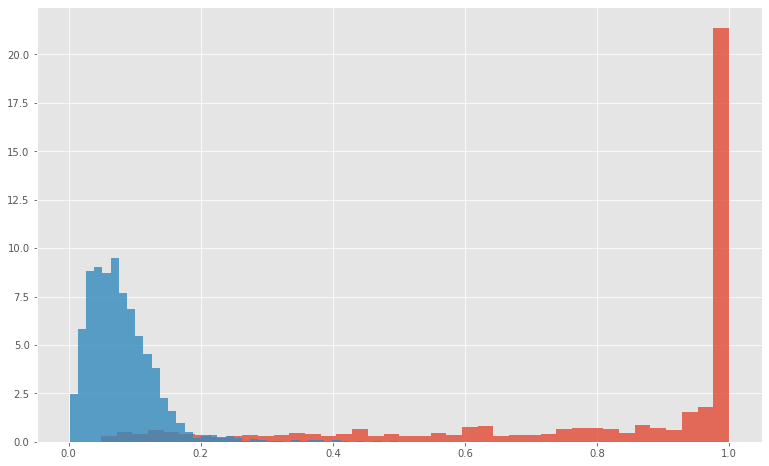

In [33]:
sub_vid_preds = old_vid_preds[
    old_vid_preds['filename'].isin(train_files) |
    old_vid_preds['swap_fake'] == 1
]

plt.style.use('ggplot')
plt.figure(figsize=(13,8))
plt.hist(
    sub_vid_preds[sub_vid_preds['swap_fake'] == 1]['median_pred'],
    density=True, bins=40, alpha=0.8
)
plt.hist(
    sub_vid_preds[sub_vid_preds['swap_fake'] == 0]['median_pred'],
    density=True, bins=40, alpha=0.8
)

(array([1.79288821, 3.9117561 , 2.93381707, 2.44484756, 2.44484756,
        1.79288821, 2.44484756, 0.97793902, 0.81494919, 0.81494919,
        0.81494919, 1.3039187 , 1.46690854, 1.95587805, 0.81494919,
        1.14092886, 0.48896951, 0.48896951, 0.65195935, 0.48896951,
        0.65195935, 0.81494919, 0.48896951, 0.65195935, 0.        ,
        0.48896951, 0.16298984, 0.        , 0.16298984, 0.        ,
        0.16298984, 0.65195935, 0.48896951, 0.32597967, 0.32597967,
        0.48896951, 0.97793902, 0.65195935, 0.48896951, 3.74876626]),
 array([0.04135127, 0.06531749, 0.08928371, 0.11324993, 0.13721615,
        0.16118236, 0.18514858, 0.2091148 , 0.23308102, 0.25704724,
        0.28101346, 0.30497967, 0.32894589, 0.35291211, 0.37687833,
        0.40084455, 0.42481076, 0.44877698, 0.4727432 , 0.49670942,
        0.52067564, 0.54464185, 0.56860807, 0.59257429, 0.61654051,
        0.64050673, 0.66447295, 0.68843916, 0.71240538, 0.7363716 ,
        0.76033782, 0.78430404, 0.80827025, 0.

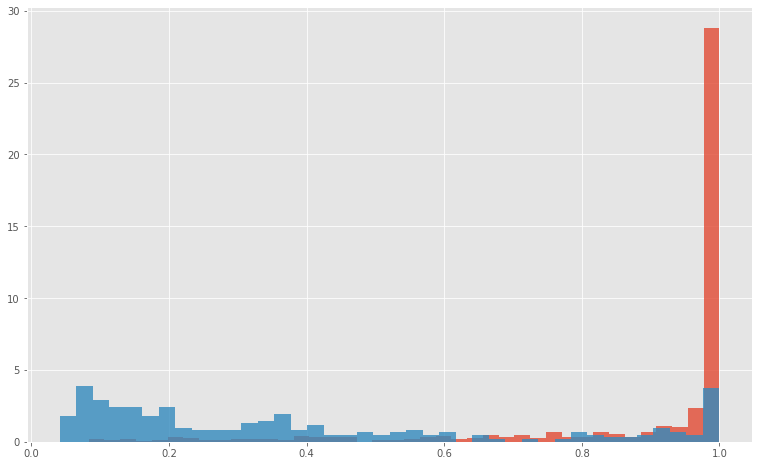

In [59]:
sub_vid_preds = old_vid_preds[
    old_vid_preds['filename'].isin(test_files) |
    old_vid_preds['swap_fake'] == 1
]

plt.style.use('ggplot')
plt.figure(figsize=(13,8))
plt.hist(
    sub_vid_preds[sub_vid_preds['swap_fake'] == 1]['3rd_quartile_pred'],
    density=True, bins=40, alpha=0.8
)
plt.hist(
    sub_vid_preds[sub_vid_preds['swap_fake'] == 0]['3rd_quartile_pred'],
    density=True, bins=40, alpha=0.8
)

In [61]:
failed_preds = old_vid_preds[
    (old_vid_preds['3rd_quartile_pred'] > 0.8) &
    (old_vid_preds['swap_fake'] == 0)
]
display(failed_preds)
print(len(failed_preds))

,filename,label,audio_fake,face_fake,swap_fake,both_fake,mean_pred,median_pred,1st_quartile_pred,3rd_quartile_pred,std_pred,max_pred,min_pred,face_no,diff,odiff
863,75b2d2cec9aa659c.mp4,0,0.0,0.0,0,0,0.542078,0.508422,0.269415,0.894703,0.328629,0.999476,0.040145,0,0.033656,-0.033656
1002,75df208133a9ff38.mp4,0,0.0,0.0,0,0,0.513515,0.431209,0.209480,0.854336,0.336742,0.999993,0.002534,0,0.082306,-0.082306
1055,55e4d92aa49c43b3.mp4,0,0.0,0.0,0,0,0.856923,0.938287,0.752128,0.986434,0.172703,0.999943,0.309458,0,-0.081364,0.081364
1065,970a916177130046.mp4,0,0.0,0.0,0,0,0.701111,0.780506,0.547387,0.933626,0.264539,0.999793,0.022276,0,-0.079395,0.079395
1206,04b84c827351f7dd.mp4,0,0.0,0.0,0,0,0.689772,0.776888,0.456310,0.954894,0.282769,0.999989,0.043215,0,-0.087117,0.087117
1276,ad9c7d5e5a94981b.mp4,0,0.0,0.0,0,0,0.527941,0.546069,0.146756,0.889737,0.347649,0.999909,0.006932,0,-0.018128,0.018128
1346,c4ccdb55cfcdefd6.mp4,0,0.0,0.0,0,0,0.496973,0.473387,0.182067,0.810839,0.320366,0.999519,0.018184,0,0.023586,-0.023586
1453,537618d25c8ba871.mp4,0,0.0,0.0,0,0,0.597881,0.614711,0.283255,0.920034,0.325721,0.999987,0.029179,0,-0.016830,0.016830
1455,4aac2a4df11152b4.mp4,0,0.0,0.0,0,0,0.797870,0.896907,0.640834,0.986100,0.224978,1.000000,0.100134,0,-0.099037,0.099037
1458,9eb3a845afdad4cf.mp4,0,0.0,0.0,0,0,0.604093,0.648450,0.350038,0.929191,0.325373,1.000000,0.009504,0,-0.044357,0.044357


48


train stats
real acc: 1.0
fake acc: 0.0
test stats
real acc: 1.0
fake acc: 0.0


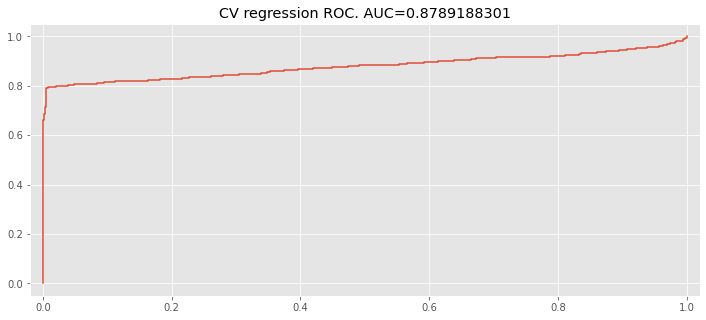

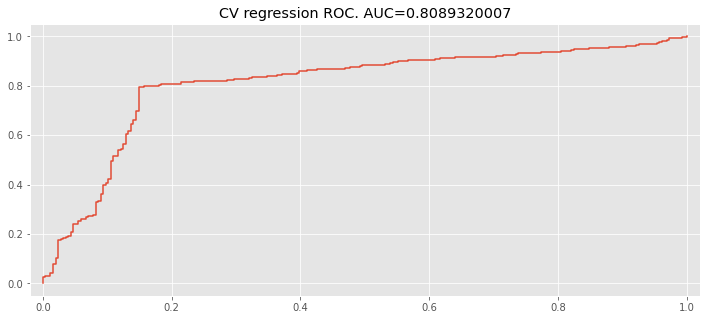

In [37]:
print('train stats')
old_vid_preds['odiff'] = -old_vid_preds['diff']
sub_draw_roc(old_vid_preds, train_files, column='odiff')
print('test stats')
sub_draw_roc(old_vid_preds, test_files, column='odiff')


<AxesSubplot:xlabel='diff', ylabel='median_pred'>

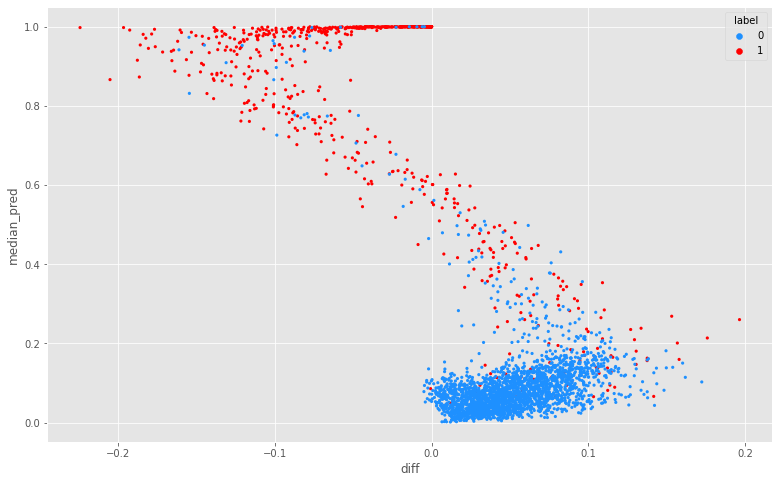

In [54]:
plt.style.use('ggplot')
plt.figure(figsize=(13,8))
sns.scatterplot(
    data=old_vid_preds, x='diff', y='median_pred', s=10,
    linewidth=0, hue='label', palette=['dodgerblue', 'red']
)

<AxesSubplot:xlabel='median_pred', ylabel='mean_pred'>

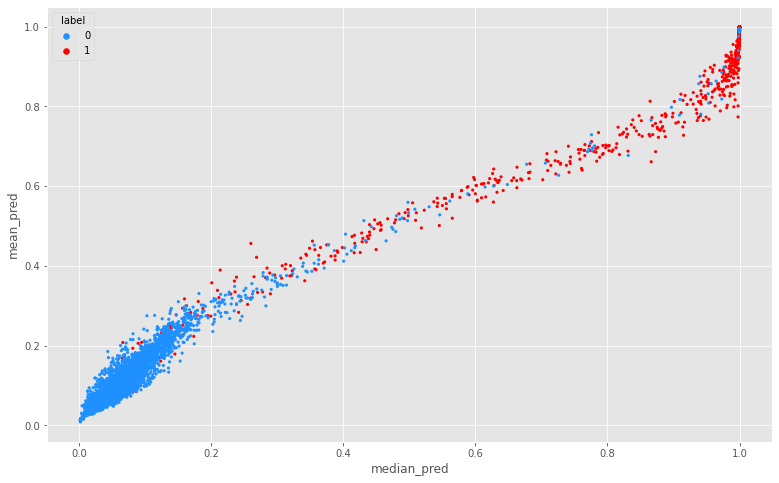

In [57]:
plt.style.use('ggplot')
plt.figure(figsize=(13,8))
sns.scatterplot(
    data=old_vid_preds, x='median_pred', y='mean_pred', s=10,
    linewidth=0, hue='label', palette=['dodgerblue', 'red']
)

<AxesSubplot:xlabel='std_pred', ylabel='median_pred'>

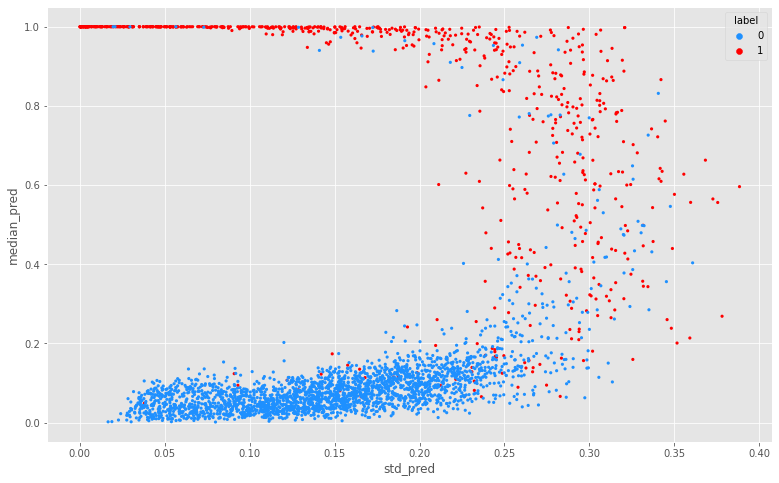

In [55]:
plt.style.use('ggplot')
plt.figure(figsize=(13,8))
sns.scatterplot(
    data=old_vid_preds, x='std_pred', y='median_pred', s=10,
    linewidth=0, hue='label', palette=['dodgerblue', 'red']
)

train stats
real acc: 0.9899782135076253
fake acc: 0.9175977653631285
test stats
real acc: 0.7109375
fake acc: 0.9175977653631285

train stats
real acc: 1.0
fake acc: 0.8198324022346368
test stats
real acc: 0.84375
fake acc: 0.8198324022346368


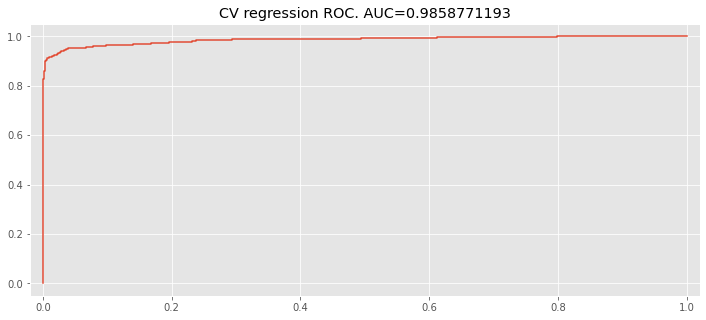

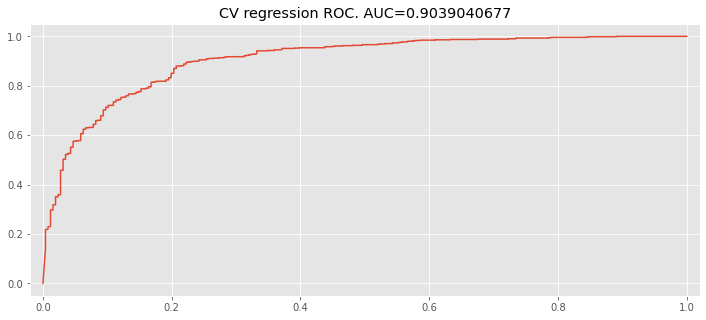

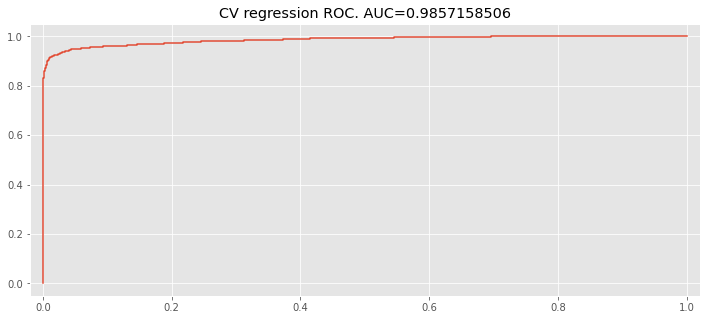

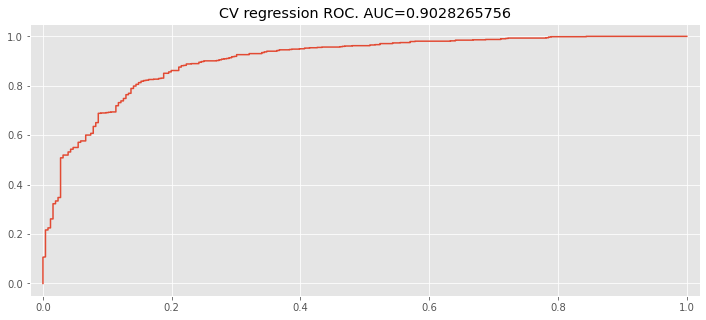

In [21]:
print('train stats')
sub_draw_roc(old_vid_preds, train_files, column='3rd_quartile_pred')
print('test stats')
sub_draw_roc(old_vid_preds, test_files, column='3rd_quartile_pred')

print('')
print('train stats')
sub_draw_roc(old_vid_preds, train_files, column='median_pred')
print('test stats')
sub_draw_roc(old_vid_preds, test_files, column='median_pred')

train stats
real acc: 1.0
fake acc: 0.659217877094972
test stats
real acc: 0.91015625
fake acc: 0.659217877094972


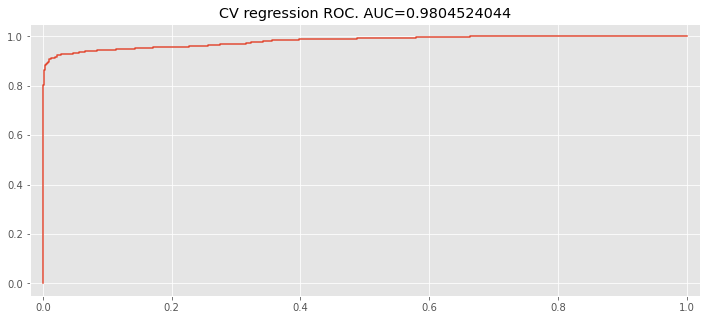

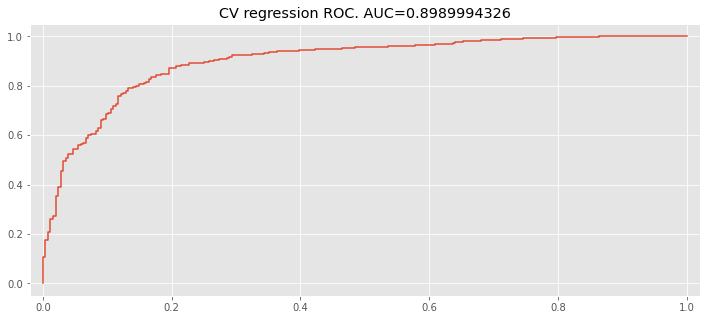

In [22]:
print('train stats')
sub_draw_roc(old_vid_preds, train_files, column='1st_quartile_pred')
print('test stats')
sub_draw_roc(old_vid_preds, test_files, column='1st_quartile_pred')

In [23]:
new_vid_preds = load_vid_preds('../stats/vid-dataset-211210-0121.csv')
display(old_vid_preds)

,filename,label,audio_fake,face_fake,swap_fake,both_fake,mean_pred,median_pred,1st_quartile_pred,3rd_quartile_pred,std_pred,max_pred,min_pred,face_no,diff
0,18351609de111566.mp4,1,0.0,0.0,1,0,0.886478,0.991882,0.877936,0.999761,0.213244,1.000000,0.180236,0,-0.105404
1,5026338ed12800bc.mp4,1,0.0,0.0,1,0,0.771807,0.937751,0.705958,0.991937,0.306803,1.000000,0.004848,0,-0.165944
2,5968740ef3396f0c.mp4,1,0.0,0.0,1,0,0.908657,0.997838,0.957127,0.999761,0.197435,1.000000,0.030951,0,-0.089181
3,50e301013618719d.mp4,1,0.0,0.0,1,0,0.689604,0.765472,0.535128,0.919209,0.280081,0.999999,0.059797,0,-0.075868
4,bc6dd15cfdfe6175.mp4,1,0.0,0.0,1,0,0.798933,0.991416,0.705039,0.999836,0.306610,1.000000,0.025240,0,-0.192483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3262,f5c4bfb20068f129.mp4,0,0.0,0.0,0,0,0.322102,0.280690,0.135136,0.444732,0.228058,0.986776,0.010469,0,0.041412
3263,b7b7b7f6db7f6e2e.mp4,0,0.0,0.0,0,0,0.019183,0.006369,0.001618,0.020698,0.034796,0.281572,0.000011,0,0.012814
3264,c3fc75289ae3b41e.mp4,0,0.0,0.0,0,0,0.056983,0.028271,0.006577,0.064418,0.086561,0.548783,0.000074,0,0.028712
3265,519e97d4c90aaa1c.mp4,0,0.0,0.0,0,0,0.155874,0.104358,0.042252,0.214259,0.175576,0.744065,0.000468,0,0.051515


train stats
real acc: 0.9991285403050109
fake acc: 0.7597765363128491
train stats
real acc: 0.9790849673202614
fake acc: 0.8645251396648045
test stats
real acc: 0.73828125
fake acc: 0.8645251396648045
real acc: 0.8671875
fake acc: 0.7597765363128491


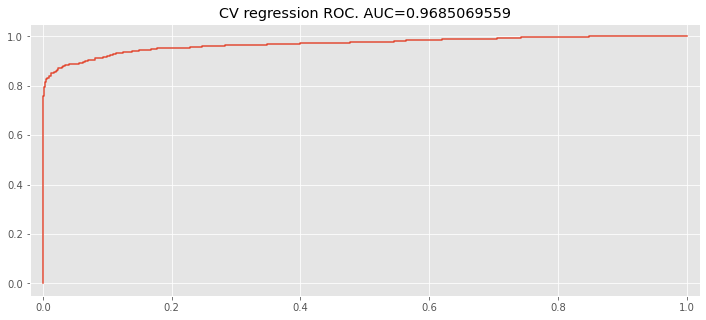

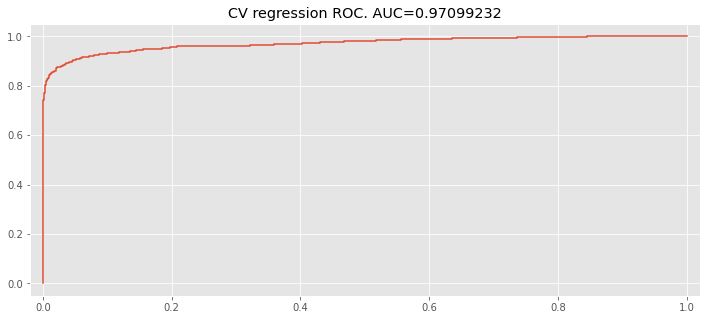

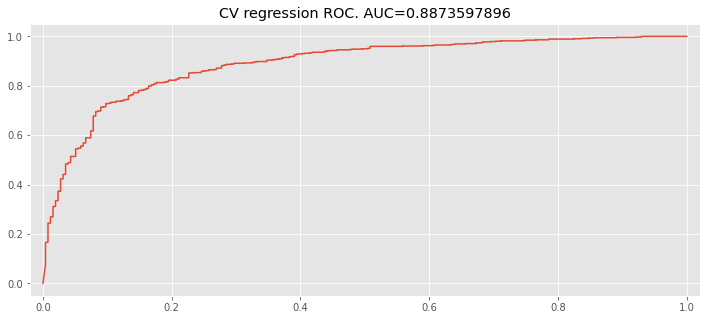

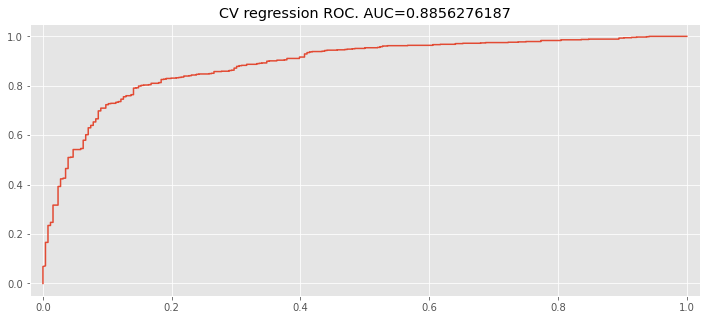

In [24]:
print('train stats')
sub_draw_roc(new_vid_preds, train_files, column='median_pred')
print('train stats')
sub_draw_roc(new_vid_preds, train_files, column='3rd_quartile_pred')
print('test stats')
sub_draw_roc(new_vid_preds, test_files, column='3rd_quartile_pred')
sub_draw_roc(new_vid_preds, test_files, column='median_pred')

In [25]:
all_new_preds = pd.read_csv('../stats/all-dataset-211210-0121.csv')
display(all_new_preds)

,filename,pred,conf,face,label
0,3dbe8314b86284eb.mp4,0.076423,0.353389,1,False
1,3dbe8314b86284eb.mp4,0.105024,0.181705,1,False
2,3dbe8314b86284eb.mp4,0.119059,0.140460,1,False
3,3dbe8314b86284eb.mp4,0.110527,0.164122,1,False
4,3dbe8314b86284eb.mp4,0.093406,0.247404,1,False
...,...,...,...,...,...
372025,b4deed8d8bcc1080.mp4,0.319450,0.030291,0,True
372026,b4deed8d8bcc1080.mp4,0.018973,0.942516,0,True
372027,b4deed8d8bcc1080.mp4,0.014014,0.966756,0,True
372028,b4deed8d8bcc1080.mp4,0.031116,0.796124,0,True


<AxesSubplot:xlabel='pred', ylabel='conf'>

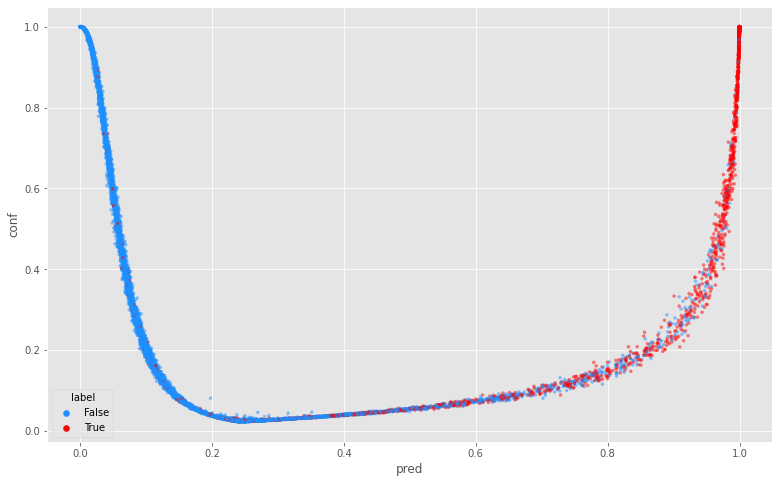

In [26]:
import random
plt.figure(figsize=(13,8))
sub_preds = all_new_preds[
    (all_new_preds['label'] == 1) |
    all_new_preds['filename'].isin(train_files)
]

sub_sample = sub_preds.sample(10000)
sns.scatterplot(
    data=sub_sample, x='pred', y='conf', hue='label', 
    linewidth=0, s=12, palette=['dodgerblue', 'red'], alpha=0.5
)

(array([ 3076.,  4234.,  3576.,  3506.,  3009.,  2907.,  2771.,  3272.,
         4253., 37757.]),
 array([1.67496000e-04, 1.00150746e-01, 2.00133997e-01, 3.00117247e-01,
        4.00100498e-01, 5.00083748e-01, 6.00066998e-01, 7.00050249e-01,
        8.00033499e-01, 9.00016750e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

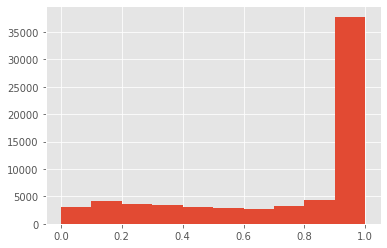

In [27]:
fake_preds = all_new_preds[all_new_preds['label'] == 1]
plt.hist(fake_preds['pred'], bins=10)